# Übersicht und Videos - Bsp. 2D Strömung in einem synthetischem Einzugsgebiet

**Situation:**

Dieses Beispiel betrachtet einen synthetischen und stark idealisierten Grundwasserleiter (Dieses Beispiel wird häufig in unseren Lehrveranstaltungen verwendet):


* Die Unterkante des Grundwasserleiters befindet sich bei 250 m NHN und die Geländeoberkante liegt bei 265 m NHN.
* Das Gebiet wird links und rechts von definierten Potentialhöhen begrenzt.
* Die hydraulische Leitfähigkeit und die Grundwasserneubildung werden als räumlich variable Parameter zoniert (s. nachfolgende Abbildung).
* Weiterhin befinden sich im Gebiet ein Fluss mit kolmatierter Sohle. Der Flusswasserstand beträgt am linken unteren Rand 260 m NHN und sinkt in Richtung rechter oberer Rand (Ecke der höher leitfähigen Zone) auf 258 m NHN ab. Die Sohle des Flusses befindet sich 5 m unterhalb des Flusswasserstandes. Der Leitwert beträgt ca. 1000 $\frac{m^2}{d}$.
* Im Gebiet wird aus zwei Brunnen Wasser entnommen: W1 fördert 2000 $\frac{m^3}{d}$ und W2 fördert 5000 $\frac{m^3}{d}$.

![](images/MAP_well.jpg)

## Allgemeine Voraussetzungen für diese Übung

### Aufbau des Modells mit FloPy

Um das Jupyter Notebook auszuführen, wird vorausgesetzt:
- die ausführbare Datei von MODFLOW-NWT ist verfügbar
- ```FloPy``` ist verfügbar (https://github.com/modflowpy/flopy)

#### Einbinden der notwendigen Bibliotheken
Zunächst werden die notwendigen Bibliotheken eingebunden. Falls Bibliotheken fehlen, müssen diese auf dem üblichen Weg (z. B. mittels Kommandozeile ```CMD``` und ```PIP INSTALL -PaketXZ```

## Einbinden aller notewendigen Packete

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as clrs
import pandas as pd
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry import (
    Polygon,
    LineString)
from IPython.display import Markdown as md

from MODELL_01 import MODELL_01_ini

ModuleNotFoundError: No module named 'pandas'

## Allgemeine Definition des Modells
Zunächst wird das Modell grundsätzlich definiert. Im nachfolgenden Skript sind die notwendigen Befehle ausführlich kommentiert.

In [2]:
###########################
# Namen und Verzeichnisse #
###########################

# Verzeichnis, in welchem die Modelldaten gespeichert werden
path = 'MODELL_01'
# Name des Modells
modelname = 'M01'
# Verwendete Version von MODFLOW
MODFLOW_version="mfnwt" #'mfnwt'
# Bezeichnung der ausführbaren Datei. Muss ggf. angepasst werden und sollte global (über PATH) zugänglich sein
MODFLOW_exe_name="/home/grabow/modflow_nwt/mfnwt" 


##############################################
# Ausdehnung des Modells und Diskretisierung #
##############################################

# Ausdehnung in x-Achse, m
Lx = 4000.
# Ausdehnung in y-Achse, m
Ly = 2500.
# Oberkante des Modells, m
ztop = 265.
# Unterkante des Modells, m
zbot = 250.
# Anzahl der Schichten (Layer)
nlay = 1
#Anzahl der Zeilen (Rows)
nrow = 25
# Anzahl der Spalten (Columns)
ncol = 40
# Eckpunkte der rechteckigen Zone mit anderem K-Wert
# Jeder Eckpunkt ist in einer Zeile gegeben mit (x, y), m
# Start ist der Punkt unten links, dann weiter gegen den Uhrzeigersinn
rectangle_vertices = [
        (2500, 1500),
        (Lx, 1500),
        (Lx, Ly),
        (2500, Ly)
    ]
# Eckpunkte des Flusses
# Hier sind der Punkt links unten und rechts oben angegeben, m
river_vertices = [
    (0,0),
    (2500, 1500)
]
# Position von W1, im Format (x,y)
w1_pos = (3000, 1600)
# Position von W2, im Format (x,y)
w2_pos = (3000, 1400)


#########################
# Grundwasserneubildung #
#########################

# Grundwasserneubilugnsrate für linke Hälfte des Modellgebiets, mm/a
r_l = 150.
# Grundwasserneubilugnsrate für rechte Hälfte des Modellgebiets, mm/a
r_r = 200.


##################################
# Hydrogeologische Eigenschaften #
##################################

# K-Wert des Modellgebiets außerhalb der Rechteck-Zone, m/s
K1 = 0.005
# K-Wert innerhalb der Rechteck-Zone, m/s
K2 = 0.002
# Vertikale Anisotropie
Vani = 1.
# Typ der Schichten (laytyp =1 für 'convertible')
laytyp = 1


#########
# Fluss #
#########

# Mächtigkeit der Flusssohle (riverbed thickness), m
m_riv = 2
# Breite des Flusses (riverbed width), m
w_riv = 100
# hydraulische Leitfähigkeit des Flussbettes, m^2/s
Rcond = 150000
# Layer der Flusssohle. Achtung: Oberster Layer = 0
riv_layer = 0
# Flusswasserstand links unten, m
riv_head_1 = 260
# Flusswasserstand rechter oberer Rand, m
riv_head_2 = 258


#################
# Festpotential #
#################

# Festpotential links, m
h_l = 260
# Festpotential rechts oben, m
h_r_o = 254
# Festpotential rechts unten, m
h_r_u = 256


###########
# Brunnen #
###########

# Entnahmerate von W1, m^3/d
w1_q = -2000
# Entnahmerate von W2, m^3/d
w2_q = -5000

In [3]:
######################
# Abgeleitete Größen #
######################

# dx, m
delc = Lx / ncol
# dy, m
delr = Ly / nrow
# dz, m
delv = (ztop - zbot) / nlay

# Zwischenschichten. Wenn es nur einen Layer gibt, enthält der array 
# nur Ober-und Unterkante
botm = np.linspace(ztop, zbot, nlay + 1)

# Grundwasserneubildungsraten von mm/a in m/s
r_l_si = r_l / (365.25 * 24 * 60 * 60 * 1000)
r_r_si = r_r / (365.25 * 24 * 60 * 60 * 1000)
# Gesamtarray der Grundwasserneubildungsrate
recharge = np.zeros((nrow, ncol))
recharge[:,:round(ncol/2)] = r_l_si
recharge[:,round(ncol/2):] = r_r_si

# Um das erstellte Grid im Hintergrundbild plotten zu können,
# müssen die Modellränder im Bild den Pixeln im Bild zugeordnet werden
pxl_l = 226
pxl_r = 1131
pxl_o = 134
pxl_u = 698

### Einstellungen zum Plotten
An dieser Stelle  werden globale Einstellungen zum Erstellen von Grafiken getroffen (z.B. die Größe)

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

<a id="intersect"></a>
### Strukturiertes Grid
Shape-Objekte wie der Fluss, die Rechteck-Zone oder die Brunnen haben nur Bezug zu den Koordinaten im Modell (x, y). Um diesen Koordinaten später Spalten und Zeilen zuzuordnen, wird zuerst ein strukturiertes Grid erzeugt. Hieraus wird ein Intersect-Objekt erstellt, mit dem dann die Shape-Objekte verschnitten werden können.

In [5]:
# Strukturiertes Grid
sgr = fgrid.StructuredGrid(delr=np.array([delr] * nrow), delc=np.array([delc] * ncol))
# Intersect-Objekt zur späteren Verschneidung
ix = GridIntersect(sgr, method="vertex", rtree=True)

/home/grabow/anaconda3/envs/flopy/lib/python3.10/site-packages/flopy/utils/gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


## Erzeugen des MODFLOW-Modells und der jeweiligen (MODFLOW)Package-Objekte

### MODFLOW-Package

In [6]:
m = flopy.modflow.Modflow(modelname, version=MODFLOW_version, 
                          exe_name=MODFLOW_exe_name, model_ws=path)

### DIS-Package 
Ein Discretization-Objekt wird erzeugt. Es enthält alle wichtigen Informationen zur Diskretisierung des Modells: 
- Anzahl der Layer, Zeilen und Spalten
- Breite der Zeilen und Spalten (hier in Meter)
- Lage der Layerschichten (hier in Meter)

Mehr Informationen zum Discretization-Package in Modflow-2005 findest Du [hier](https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/dis.html).

In [7]:
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:])

Das resultierende Grid mit Zeilen und Spalten sieht in der Draufsicht so aus:

(0.0, 2500.0, 0.0, 4000.0)

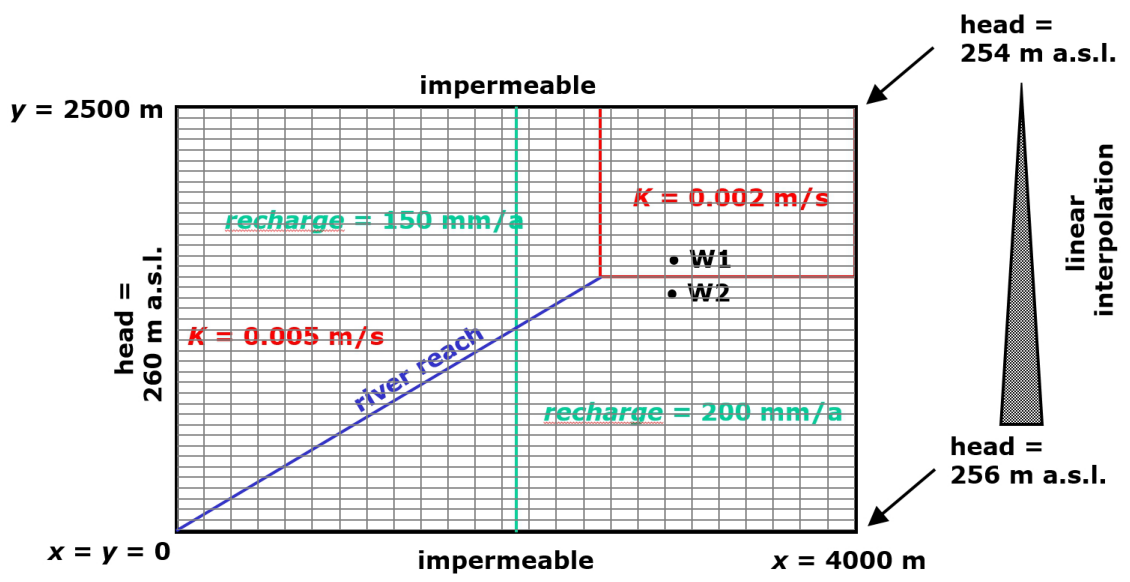

In [8]:
# CELL TO HIDE

# Einladen der Draufsicht
img = plt.imread("images/MAP_well.jpg")

# Erstellen der Figure und der Axes
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Bild in die Axes einfügen
ax.imshow(img)
# Grid in die Box einfügen
ax_child = ax.inset_axes([pxl_l, pxl_o, pxl_r-pxl_l,pxl_u-pxl_o], transform=ax.transData)
ax_child.patch.set_alpha(0.0)
sgr.plot(ax=ax_child)

# Ausschalten aller automatischen Axenbeschriftungen
ax.axis("off")
ax_child.axis("off")

### BAS-Package
Ein Basic-Objekt wird erzeugt. Es enthält weitere Informationen zu den Zellen:
- Ob eine Zelle entweder aktiv oder inaktiv ist oder ein definiertes Druckpotential besitzt
- Das Druckpotential der Zelle. Für aktive Zellen ist dies das Anfangspotential zu Beginn der Simulation. Sind die Zellen inaktiv oder haben ein definiertes Druckpotential wird das hier angegebene Potential über die gesamte Simulation verwendet

Mehr Informationen zum Basic-Package in Modflow-2005 findest Du [hier](https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/bas6.html).

<a id="bas"></a>

In [9]:
# Festpotential entlang des linken Modellrands als array
head_left = np.ones(nrow, dtype=int) * h_l
# Festpotential entlang des rechten Modellrands als array (lineare Interpolation)
head_right = np.linspace(h_r_u, h_r_o, nrow)

# ibound array zur Defintion aktiver oder inaktiver Zellen oder Zellen mit definiertem Druckpotential
# Jeder Zelle (layer, x, y) wird ein Wert zugeordnet. Die möglichen Werte sind:
# ibound(layer, x, y) < 0: Zelle mit definiertem Druckpotential
# ibound(layer, x, y) = 0: Zelle inaktiv
# ibound(layer, x, y) > 0: Zelle aktiv
ibound = np.ones((nlay, nrow, ncol), dtype=int) 
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

# Anfangspotential und Festpotential
strt = ztop / 2 * np.ones((nlay, nrow, ncol), dtype=float)
strt[:, :, 0] = head_left
strt[:, :, -1] = head_right
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

### OC-Package
Ein Output-Control-Objekt wird erzeugt. Hierdruch ist definiert, welche Ausgabe das Modell zu welchem Zeitschritt und welcher Stressperiode erstellen soll. Die möglichen Ausgaben sind:
- Druckpotential
- Absenkung
- Volumen-Budget
- iBound-Array ([hier definiert](#bas))

Für einige Ausgaben kann zusätzlich das Format (Binary oder Fortran-Formate) und die Art der Ausgabe (durch Print oder Speichern) festgelegt werden.

Mehr Informationen zum OC-Package in Modflow-2005 findest Du [hier](https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/oc.html).

In [10]:
# Zum Zeitschritt 0 und Stressperiode 0 (Standard bei Steady-State)
# soll das Druckpotential und des Volumen-Budget gespeichert und ausgegeben werden
words = ["print head", "print budget", "save head", "save budget"]
oc = flopy.modflow.ModflowOc(m, stress_period_data={(0,0): words}, compact=True)

### NWT-Package
Ein NWT-Objekt wird erzeugt. Bei NWT handelt sich um ein eigenständiges Lösungsverfahren, das vor allem das dauerhafte Trockenfallen von Zellen im ungespannten Grundwasserfluss verhindert. Dieses soll hier verwendet werden.

Mehr Informationen zu Modflow-NWT findest Du [hier](https://www.usgs.gov/software/modflow-nwt-newton-formulation-modflow-2005).

In [11]:
nwt = flopy.modflow.ModflowNwt(m)

### RCH-Package
Ein Recharge-Objekt wird erzeugt. Es enthält alle Informationen über die Grundwasserneubildung im Modell (wo und wie viel).

Mehr Informationen zum Recharge-Package findest Du [hier](https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/rch.html).

In [12]:
rch = flopy.modflow.mfrch.ModflowRch(m, nrchop=1, rech=recharge, extension='rch')

### UPW-Package 
Ein Upstream-weighting-Objekt wird erzeugt. Das **UP**stream **W**eightning Package beschreibt den Fluss zwischen zwei Zellen für Modflow-NWT.  

Mehr Informationen zu UPW findest Du [hier](https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/upw_upstream_weighting_package.html).

Das UPW Package benötigt die hydraulische Leitfähigkeit für jede Zelle im Modell. Hierfür wird ein Array mit Größe des Modellgrids (nrow x ncol) erstellt, in dem jeder Zelle erst einmal K1 zugewiesen wird. Dann wird das Rechteck Shape-Objekt mit dem [zuvor erstellelten Intersect-Objekt](#intersect) verschnitten, um so die Zeilen und Spalten zu erhalten, in denen K2 gilt. An diesen Stellen wird K1 im Array dann mit K2 ersetzt. 

<AxesSubplot:title={'center':'hk layer 1'}>

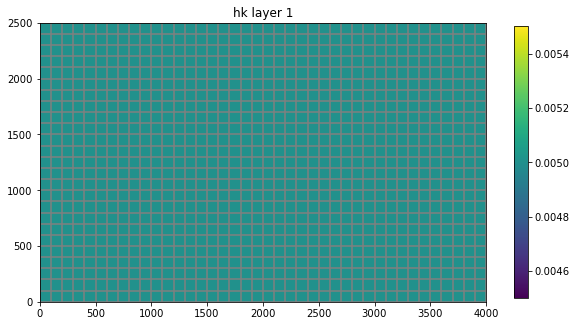

In [13]:
# Rechteck als Polygon-Objekt
rectangle_shape = Polygon(rectangle_vertices)
# Verschneiden des Polygon-Objektes mit dem Intersect-Objekt
rectangle_rcarray = ix.intersect(rectangle_shape)

# Zuweisung von K1 und K2 zu den Spalten und Zeilen
k_zones = np.ones((nlay, nrow, ncol)) * K1
for x_idx, y_idx in rectangle_rcarray.cellids:
    k_zones[:,x_idx, y_idx] = K2

# Erzeugen der UPW Daten
upw = flopy.modflow.ModflowUpw(m, hk=k_zones, vka=Vani, laytyp=laytyp)

# Bildschirmausgabe der K-Werte sowie der Diskretisierung
upw.hk.plot(colorbar=True, grid=True)

# Speichern der Matrix für die spätere Kalibrierung mit PEST (Schauen Sie sich die Datei im Modellverzeichnis an)
#np.savetxt(os.path.join(path,'K_ZONEN.dat'), Kzones, delimiter=' ', fmt='%i')

###  RIV-Package
Das RIV-Package wird benutzt, um Randbedingungen 3. Art zu simulieren. In diesem Modell soll der Fluss so beschrieben werden. Um ein River-Objekt zu erzeugen, wird eine Tabelle benötigt, die alle Informationen zur Lage und Art der Randbedingung enthält.

#### Theoretischer Aufbau der Tabelle
In der Tabelle werden alle Zellen aufgeführt, die dem Fluss zugeordnet sind. Jede Zeile der Tabelle beschreibt dabei eine Zelle. Diese ist definiert durch ihren Layer und ihre Spalten - und Zeilennummer. Zu jeder Zelle sind folgende hydraulischen Größen angegeben:
- Flusswasserstand
- Hydraulische Leitfähigkeit des Flussbettes
- Höhe des Flussbettes

Als Beispiel:

In [14]:
# CELL TO HIDE
string = f""" Layer | Zeile | Spalte | Flusswasserstand | Hydr. LF des Flussbetts | Höhe des Flussbetts
------ | ------ | ------ | ------ | ------ | ------ 
0 | 0 | 0 | {riv_head_1} | {Rcond} |  {riv_head_1 - 5} 
... | ... | ... | ... | ... |  ... """

md(string)

 Layer | Zeile | Spalte | Flusswasserstand | Hydr. LF des Flussbetts | Höhe des Flussbetts
------ | ------ | ------ | ------ | ------ | ------ 
0 | 0 | 0 | 260 | 150000 |  255 
... | ... | ... | ... | ... |  ... 

#### Erstellen der Tabelle

Um die Zellen zu ermitteln, die zum Fluss dazugehören, muss - wie zuvor beim Rechteck Shape-Objekt - das Fluss Shape-Objekt mit dem Intersect-Objekt verschnitten werden.
Das Fluss Shape-Objekt ist dabei eine Linie. Wie in der Abbildung dargestellt, werden alle Zellen, die von der Linie geschnitten werden, dem Fluss zugeordnet.
<a id="river"></a>

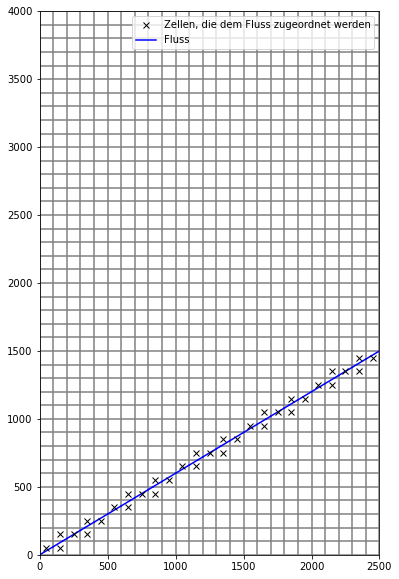

In [15]:
# Fluss als Linien-Objekt
river_shape = LineString(river_vertices)
# Verschneiden des Linien-Objektes mit dem Intersect-Objekt 
river_rcarray = ix.intersect(river_shape)

# Plotten der Verschneidung zur Veranschaulichung
fig, ax = plt.subplots(1, 1)
sgr.plot(ax=ax)
riv = ix.plot_linestring(river_rcarray, ax=ax, color="blue", label="Fluss")

for irow, icol in river_rcarray.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="Zellen, die dem Fluss zugeordnet werden",
    )

ax.legend([h2, riv.get_lines()[0]], [i.get_label() for i in [h2, riv.get_lines()[0]]], loc="best", );

Jetzt sind die Zeilen und Spalten bekannt. Hieraus wird die Tablle erstellt, die jetzt nach und nach erweitert wird. 

In [16]:
# Erstellen der Tabelle aus den Zeilen und Spalten
river_df = pd.DataFrame(river_rcarray.cellids.tolist(), columns=["row", "column"])

Jetzt wird die Layer-Spalte hinzugefügt

In [17]:
# Hinzufügen der Layer-Spalte zur Tabelle
layer = riv_layer
river_df["layer"] = [layer] * river_df.shape[0]

Als nächstes wird der Flusswasserstand für jede Zelle ermittelt. Der Flusswasserstand ist links unten im Modell und rechts oben definiert. Damit kann er linear entlang der Fluss-Linie interpoliert werden. Der Mittelpunkt einer Zelle liegt allerdings nie direkt auf der Flusslinie ([siehe Abbildung](#river)). Als Kompromiss wird einer Zelle der Flusswasserstand von dem Punkt entlang der Flusslinie zugeordnet, der am nächsten am Mittelpunkt der Zelle ist. Am Ende der Berechnung werden die Flusswasserstände als Spalte an die Tabelle beigefügt.

In [18]:
# Bestimmen des des Wasserstands für jede Zelle, basierend auf der kuerzesten Entfernung zwischen 
# Zellmittelpunkt und dem tatsächlichen Verlauf des Flusses

def get_x_intersect(slope, n, x_cell, y_cell):
    x_ict = (y_cell + x_cell / slope - n) / (slope + 1 / slope)
    return x_ict
def get_y_intersect(slope, n, x_itc):
    y_itc = slope * x_itc + n
    return y_itc
def get_length_intersect(x_itc, y_itc):
    length_itc = np.sqrt(x_itc**2 + y_itc**2)
    return length_itc
def get_val_intersect(length_end, length_itc, val_start, val_end):
    val_itc = (val_end - val_start) * length_itc / (length_end) + val_start
    return val_itc

river_stage = np.array([])
length_end = river_shape.length
slope = (river_shape.xy[1][1] - river_shape.xy[1][0]) / (river_shape.xy[0][1] - river_shape.xy[0][0])
n = river_shape.xy[1][0] - slope * river_shape.xy[0][0]
for irow, icol in river_rcarray.cellids:
        x_cell, = sgr.xcellcenters[0, icol],
        y_cell, = sgr.ycellcenters[irow, 0],
        x_itc = get_x_intersect(slope, n, x_cell, y_cell)
        y_itc = get_y_intersect(slope, n, x_itc)
        length_itc = get_length_intersect(x_itc, y_itc)
        val_itc = get_val_intersect(length_end, length_itc, riv_head_1, riv_head_2)
        river_stage = np.append(river_stage, val_itc)

river_df["stage"] = river_stage

Die Höhe des Flussbettes ergibt sich durch den berechneten Flusswasserstand minus der Flusstiefe. Diese ist in der Aufgabe als kostant 5m angenommen. Das Ergebnis wird als Spalte der Tabelle beigefügt.

In [19]:
# Hinzufügen der Flussbett-Spalte zur Tabelle
river_df["rbot"] = river_stage - 5

Die hydraulische Leitfähigkeit des Flussbettes ist in der Aufgabe definiert und ist für alle Zellen gleich. Das Ergebnis wird als Spalte der Tabelle beigefügt.

In [20]:
# Hinzufügen der Leitfähigkeits-Spalte zur Tabelle
river_df["Rcond"] = [Rcond] * river_df.shape[0]

Jetzt ist die Tabelle komplett:

In [21]:
# Umsortieren der Spalten in die richtige Reihenfolge
river_df = river_df[["layer","row","column","stage","Rcond","rbot"]]

# Ausgeben der Tabelle
print(river_df)

    layer  row  column       stage   Rcond        rbot
0       0   25      23  258.105882  150000  253.105882
1       0   25      24  258.047059  150000  253.047059
2       0   26      21  258.258824  150000  253.258824
3       0   26      22  258.200000  150000  253.200000
4       0   26      23  258.141176  150000  253.141176
5       0   27      20  258.352941  150000  253.352941
6       0   27      21  258.294118  150000  253.294118
7       0   28      18  258.505882  150000  253.505882
8       0   28      19  258.447059  150000  253.447059
9       0   29      16  258.658824  150000  253.658824
10      0   29      17  258.600000  150000  253.600000
11      0   29      18  258.541176  150000  253.541176
12      0   30      15  258.752941  150000  253.752941
13      0   30      16  258.694118  150000  253.694118
14      0   31      13  258.905882  150000  253.905882
15      0   31      14  258.847059  150000  253.847059
16      0   32      11  259.058824  150000  254.058824
17      0 

Mit der fertigen Tabelle kann das River-Objekt nun erstellt werden

In [22]:
# Kovertieren des pandas DataFrames in ein numpy array
rivdata = river_df.values

# Zuordnen der konvertierten Tabelle zur Stressperiode
rivdata = {0: rivdata}

# Erzeugen des RIV Objektes
riv = flopy.modflow.mfriv.ModflowRiv(m, ipakcb=53, stress_period_data=rivdata, 
                                     extension='riv', unitnumber=18, options=None, naux=0)

### WEL-Package
Das WEL-Package wird benutzt, um Randbedingungen 2. Art zu simulieren. In diesem Modell sollen die beiden Brunnen W1 und W2 so beschrieben werden. Die Brunnen sind in (x,y)-Koordinaten angegeben. Das heißt, es muss wieder mit dem Intersect-Objekt gearbeitet werden, um zu den Spalten-und Zeilennummer zu gelangen.

In [23]:
# Verschneiden der Brunnen-Objekte mit dem Intersect-Objekt
w1_x_idx, w1_y_idx = sgr.intersect(w1_pos[0], w1_pos[1])
w2_x_idx, w2_y_idx = sgr.intersect(w2_pos[0], w2_pos[1])

# Umrechnen der Förderraten von m^3/d in m^3/s
w1_q_si = w1_q / (24 * 60 * 60)
w2_q_si = w2_q / (24 * 60 * 60)

# Erzeugen der Daten für Brunnen (Layer, Row, Column, Förderraten) für die Stressperioden
bflux = {
    0:[[0, w1_y_idx, w1_x_idx, w1_q_si],
      [0, w2_y_idx, w2_x_idx, w2_q_si]]
}

# Erzeugen des WEL-Objektes
wel = flopy.modflow.ModflowWel(m, stress_period_data=bflux)

structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


Exception: x, y point given is outside of the model area

## Kontrolle der bisherigen Eingaben
Das Modell ist fertig aufgebaut. Zur Kontrolle werden nochmal alle eingebundenen Packete ausgegeben:

In [ ]:
m.get_package_list()

Zudem wird das Modells mit den einzelnen Elemente (Zonen, Beobachtungspunkte, Randbedingungen) nochmals visualisiert:

In [ ]:
# Figure und Axis
fig, ax = plt.subplots()
# Ausdehnung für imshow()
extent = [0, Lx, 0, Ly]

# Dummy-Array, der später geplottet wird und dessen unterschiedliche Werte 
# das jeweilige Element anzeigen
plot_array = k_zones.copy()

# Einzigartige Dummy-Werte für Fluss und Brunnen, um sie von K1 und K2
# im Dummy-Array abgrenzen zu können
dummy_river = min(K1, K2) + abs(K1 - K2) * 0.25
dummy_well = min(K1, K2) + abs(K1 - K2) * 0.75
plot_array[river_df.row, river_df.column] = dummy_river
plot_array[[w1_x_idx, w2_x_idx], [w1_y_idx, w1_y_idx]] = dummy_well

# Definition der Farben nach den Wertegrenzen der Dummy-Werte
colors_map = ("orange", "mediumblue", "black", "wheat")
cmap = clrs.LinearSegmentedColormap.from_list('Custom', colors_map, len(colors_map))
boundaries = [min(K1, K2),
              (dummy_river - min(K1, K2)) / 2 + min(K1, K2), 
              (dummy_well - dummy_river) / 2 + dummy_river,
              (max(K1, K2) - dummy_well) / 2 + dummy_well, 
              max(K1, K2)]
norm = clrs.BoundaryNorm(boundaries, cmap.N, clip=True)

# Darstellen des Dummy-Arrays
im = ax.imshow(plot_array, extent=extent, interpolation='None', cmap=cmap, norm=norm)

# Zuordnen der Farben für die Legende
label_colors = [im.cmap(im.norm(K1)),
         im.cmap(im.norm(K2)),
         im.cmap(im.norm(dummy_river)),
         im.cmap(im.norm(dummy_well))]
label_names = ["K1",
              "K2",
              "Fluss",
              "Brunnen"]
# Legende als einzelne Patches
patches = [ mpatches.Patch(color=label_colors[i], label=label_names[i]) for i in range(len(label_colors)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# Darstellung des Grids
ax.set_xticks(np.arange(0, Lx, 500))
ax.set_xticks(np.arange(0, Lx, delc), minor=True)
ax.set_yticks(np.arange(0, Ly, 500))
ax.set_yticks(np.arange(0, Ly, delr), minor=True)
ax.grid(which='both')

# Definition des Titels
plt.title("Übersicht zu den verschiedenen Elementen im Modell")
plt.show()

## Ausführen des Modells
An dieser Stelle werden die Input-Daten in das Modellverzeichnis geschrieben und das Grundwasserströmungsmodells berechnet. Die Simulation ist danach abgeschlossen und die Ergebnisse finden sich im Modellverzeichnis.

In [ ]:
# Schreiben der Modell-Input-Files
m.write_input()

# Ausführen des Modells
m.run_model()